# Checklist

## Import

In [22]:
import cv2
import numpy as np
import os
from pycocotools.coco import COCO
import pandas as pd
import seaborn as sns
import torch
import matplotlib.pyplot as plt
import warnings
from tqdm import tqdm
import json
import random

import mmcv
from matplotlib.ticker import MultipleLocator
from mmcv import Config
from mmcv.ops import nms
from mmdet.core.evaluation.bbox_overlaps import bbox_overlaps
from mmcv.runner import (get_dist_info, load_checkpoint,
                         wrap_fp16_model)
from mmdet.apis import (single_gpu_test, inference_detector)
from mmdet.datasets import (build_dataloader, build_dataset,
                            replace_ImageToTensor)
from mmdet.models import build_detector
from mmdet.utils import (build_dp, compat_cfg, get_device,
                         replace_cfg_vals, setup_multi_processes,
                         update_data_root)
from mmdet.core import get_classes
from pycocotools.cocoeval import COCOeval
from multiprocessing import Pool
import copy

## 사용한 Datast의 분포 확인하기

### 경로 설정

In [ ]:
data_dir = "../../../../../dataset"
ann_file = "train.json"

### Dataset 정의

In [7]:
class EDADataset:
    def __init__(self, data_dir, ann_file):
        """
        annotation: annotation 파일 위치
        data_dir: data가 존재하는 폴더 경로
        category_id: ["General trash", "Paper", "Paper pack", "Metal", "Glass",
                        "Plastic", "Styrofoam", "Plastic bag", "Battery", "Clothing"]
        """

        super().__init__()
        self.data_dir = data_dir
        self.annotation = os.path.join(self.data_dir, ann_file)

        info = []
        # coco annotation 불러오기 (coco API)
        self.coco = COCO(self.annotation)
        for image_id in self.coco.getImgIds():
            image_info = self.coco.loadImgs(image_id)[0]
            annotation_id = self.coco.getAnnIds(imgIds=image_info["id"])
            annotation_info_list = self.coco.loadAnns(annotation_id)

            file_name = os.path.join(self.data_dir, image_info["file_name"])

            # [x_min, x_max, y_min, y_max]
            for annotation in annotation_info_list:
                info.append(
                    [
                        image_id,
                        file_name,
                        int(annotation["category_id"]),
                        float(annotation["bbox"][0]),
                        float(annotation["bbox"][0]) + float(annotation["bbox"][2]),
                        float(annotation["bbox"][1]),
                        (float(annotation["bbox"][1]) + float(annotation["bbox"][3])),
                        float(annotation["bbox"][2]),
                        float(annotation["bbox"][3]),
                        float(annotation["area"]),
                    ]
                )

        self.df = pd.DataFrame(
            info,
            columns=[
                "img_id",
                "img_path",
                "label",
                "x_min",
                "x_max",
                "y_min",
                "y_max",
                "width",
                "height",
                "area",
            ],
        )

        self.df["center_x"] = (self.df["x_max"] + self.df["x_min"]) / 2
        self.df["center_y"] = (self.df["y_max"] + self.df["y_min"]) / 2

    def grouping_bbox_per_img(self):
        """
        Using Example:
            eda = EDADataset()
            img_df, img_df_idx = eda.grouping_bbox_per_img()
            eda.df.iloc[img_df_idx[1]] -> 하나의 이미지에 있는 bbox의 정보를 나타냄
        Return:
            Return group index (dict type)
        """
        group_df = self.df.groupby("img_id")
        return group_df, group_df.groups

    def grouping_bbox_per_label(self):
        """
        Using Example:
            eda = EDADataset()
            label_df, label_df_idx = eda.grouping_bbox_per_label()
            eda.df.iloc[label_df_idx[1]] -> 같은 class에 대한 이미지들의 정보를 나타냄
        Return:
            Return group index (dict type)
        """
        group_df = self.df.groupby("label")
        return group_df, group_df.groups

### Class 정의

In [33]:
class_space_names = [
    "General\ntrash",
    "Paper",
    "Paper\npack",
    "Metal",
    "Glass",
    "Plastic",
    "Styrofoam",
    "Plastic\nbag",
    "Battery",
    "Clothing",
]
class_names = [
    "General trash",
    "Paper",
    "Paper pack",
    "Metal",
    "Glass",
    "Plastic",
    "Styrofoam",
    "Plastic bag",
    "Battery",
    "Clothing",
]

### Class Distribution 확인

In [ ]:
dataset = EDADataset(data_dir, ann_file)
df = dataset.df

img_df, img_df_idx = dataset.grouping_bbox_per_img()
label_per_img = (img_df["label"].count()).sort_values(ascending=False)

label_df, label_df_idx = dataset.grouping_bbox_per_label()

labels = df["label"].value_counts().sort_values(ascending=False)
class_id = labels.index.values
class_ = np.array(class_space_names)
class_ = class_[class_id]
colors = ["#87CEFA"] * len(class_space_names)
plt.bar(class_, labels, color=colors)
plt.xticks(fontsize=8)
print()
for idx, val in enumerate(labels):
    plt.text(
        x=idx,
        y=val,
        s=f'({(val / labels.sum())*100:.2f})',
        va="bottom",
        ha="center",
        fontsize=8,
        fontweight="semibold",
        color='r'
    )
    plt.text(
        x=idx,
        y=val+150, # 수치들이 plot 밖으로 넘어가는 경우에 변경해주세요.
        s=val,
        va="bottom",
        ha="center",
        fontsize=8,
        fontweight="semibold",
    )
plt.title("Class Distribution")
plt.tight_layout()
plt.show()

### 하나의 Image에 그려지는 Bounding Box 개수

#### 전체 보기

In [ ]:
dataset = EDADataset(data_dir, ann_file)
df = dataset.df

img_df, img_df_idx = dataset.grouping_bbox_per_img()
cnt = img_df['label'].count().value_counts()
x = cnt.index.values
y = cnt.values

train_colors = ["#87CEFA"] * len(x)
plt.bar(x, y, color=train_colors)
for idx, val in enumerate(x):
    plt.text(
        x=x[idx],
        y=y[idx],
        s=y[idx],
        va="bottom",
        ha="center",
        fontsize=8,
        fontweight="semibold",
    )
plt.title("Class Count Per Image")
plt.tight_layout()
plt.show()

#### 자세히 보기

In [ ]:
dataset = EDADataset(data_dir, ann_file)
df = dataset.df

img_df, img_df_idx = dataset.grouping_bbox_per_img()
cnt = img_df['label'].count().value_counts()[20:]
x = cnt.index.values
y = cnt.values

train_colors = ["#87CEFA"] * len(x)
plt.bar(x, y, color=train_colors)
for idx, val in enumerate(x):
    plt.text(
        x=x[idx],
        y=y[idx],
        s=y[idx],
        va="bottom",
        ha="center",
        fontsize=8,
        fontweight="semibold",
    )
plt.title("Class Count Per Image")
plt.tight_layout()
plt.show()

### 하나의 Image에 그려지는 Bounding Box의 Class 개수

In [ ]:
dataset = EDADataset(data_dir, ann_file)
df = dataset.df

img_df, img_df_idx = dataset.grouping_bbox_per_img()
unique_cnt = np.array([len(arr) for arr in img_df['label'].unique().values])
x, y = np.unique(unique_cnt, return_counts=True)

train_colors = ["#87AAF6", "#87BBF6", "#87CCF6", "#87DDF6", "#87EEF6", "#87FFEB", "#87FFA2"]
plt.bar(x, y, color=train_colors)
for idx, val in enumerate(x):
    plt.text(
        x=x[idx],
        y=y[idx],
        s=y[idx],
        va="bottom",
        ha="center",
        fontsize=10,
        fontweight="semibold",
    )
plt.title("Unique Class Count Per Image")
plt.tight_layout()
plt.show()

### Bounding Box의 크기 살펴보기

- mAP_s: < 32*32
- mAP_m: < 64*64
- mAP_l: >= 64*64

In [ ]:
dataset = EDADataset(data_dir, ann_file)
df = dataset.df

area = [0, 32, 64, 128, 256, 512, 1024]
train_area = [len(df[(df['area'] >= area[i]**2) & (df['area'] < area[i+1]**2)]) for i in range(len(area)-1)]

train_x = [f'${area[i]}^2$<=\n<${area[i+1]}^2$' for i in range(len(area)-1)]

train_y = train_area

train_colors = ["#87CEFA"] * len(train_x)
plt.bar(train_x, train_y, color=train_colors)
plt.xticks(fontsize=8)
for idx, val in enumerate(train_x):
    plt.text(
        x=train_x[idx],
        y=train_y[idx],
        s=train_y[idx],
        va="bottom",
        ha="center",
        fontsize=8,
        fontweight="semibold",
    )
plt.title("Number of Bounding Boxes in Each Area Range")
plt.tight_layout()
plt.show()

### Bounding Box Center Point 위치

In [ ]:
dataset = EDADataset(data_dir, ann_file)
df = dataset.df

img_df, img_df_idx = dataset.grouping_bbox_per_img()
label_per_img = (img_df["label"].count()).sort_values(ascending=False)

label_df, label_df_idx = dataset.grouping_bbox_per_label()

fig, ax = plt.subplots(5, 2, figsize=(6, 16))
for label in range(len(class_names)):
    new_df = df[df["label"] == label]

    img = np.zeros((1024, 1024, 3), dtype="uint8")
    sns.scatterplot(x="center_x", y="center_y", data=new_df, color="#87CEFA", ax=ax[label//2][int(label%2)])
    row, col = label//2, int(label%2)
    ax[row][col].set_xlim(0, 1024)
    ax[row][col].set_ylim(0, 1024)
    ax[row][col].axis("off")
    ax[row][col].imshow(img, extent=[0, 1024, 0, 1024])
    ax[row][col].set_title(class_names[label])
plt.tight_layout()
plt.show()

## Confusion Matrix

- Validation dataset에 대해 Class를 잘 예측했는지 알아보겠습니다.

### 필요한 함수들 정의

In [60]:
def calculate_confusion_matrix(dataset,
                               results,
                               score_thr=0,
                               nms_iou_thr=None,
                               tp_iou_thr=0.5):
    """Calculate the confusion matrix.

    Args:
        dataset (Dataset): Test or val dataset.
        results (list[ndarray]): A list of detection results in each image.
        score_thr (float|optional): Score threshold to filter bboxes.
            Default: 0.
        nms_iou_thr (float|optional): nms IoU threshold, the detection results
            have done nms in the detector, only applied when users want to
            change the nms IoU threshold. Default: None.
        tp_iou_thr (float|optional): IoU threshold to be considered as matched.
            Default: 0.5.
    """
    num_classes = len(dataset.CLASSES)
    confusion_matrix = np.zeros(shape=[num_classes, num_classes])
    assert len(dataset) == len(results)
    prog_bar = mmcv.ProgressBar(len(results))
    for idx, per_img_res in enumerate(results):
        if isinstance(per_img_res, tuple):
            res_bboxes, _ = per_img_res
        else:
            res_bboxes = per_img_res
        ann = dataset.get_ann_info(idx)
        gt_bboxes = ann['bboxes']
        labels = ann['labels']
        analyze_per_img_dets(confusion_matrix, gt_bboxes, labels, res_bboxes,
                             score_thr, tp_iou_thr, nms_iou_thr)
        prog_bar.update()
    return confusion_matrix


def analyze_per_img_dets(confusion_matrix,
                         gt_bboxes,
                         gt_labels,
                         result,
                         score_thr=0,
                         tp_iou_thr=0.5,
                         nms_iou_thr=None):
    """Analyze detection results on each image.

    Args:
        confusion_matrix (ndarray): The confusion matrix,
            has shape (num_classes + 1, num_classes + 1).
        gt_bboxes (ndarray): Ground truth bboxes, has shape (num_gt, 4).
        gt_labels (ndarray): Ground truth labels, has shape (num_gt).
        result (ndarray): Detection results, has shape
            (num_classes, num_bboxes, 5).
        score_thr (float): Score threshold to filter bboxes.
            Default: 0.
        tp_iou_thr (float): IoU threshold to be considered as matched.
            Default: 0.5.
        nms_iou_thr (float|optional): nms IoU threshold, the detection results
            have done nms in the detector, only applied when users want to
            change the nms IoU threshold. Default: None.
    """
    true_positives = np.zeros_like(gt_labels)
    for det_label, det_bboxes in enumerate(result):
        if nms_iou_thr:
            det_bboxes, _ = nms(
                det_bboxes[:, :4],
                det_bboxes[:, -1],
                nms_iou_thr,
                score_threshold=score_thr)
        ious = bbox_overlaps(det_bboxes[:, :4], gt_bboxes)
        for i, det_bbox in enumerate(det_bboxes):
            score = det_bbox[4]
            det_match = 0
            if score >= score_thr:
                for j, gt_label in enumerate(gt_labels):
                    if ious[i, j] >= tp_iou_thr:
                        det_match += 1
                        if gt_label == det_label:
                            true_positives[j] += 1  # TP
                        confusion_matrix[gt_label, det_label] += 1
                if det_match == 0:  # BG FP
                    confusion_matrix[-1, det_label] += 1
    for num_tp, gt_label in zip(true_positives, gt_labels):
        if num_tp == 0:  # FN
            confusion_matrix[gt_label, -1] += 1


def plot_confusion_matrix(confusion_matrix,
                          labels,
                          save_dir=None,
                          show=True,
                          title='Normalized Confusion Matrix',
                          color_theme='plasma'):
    """Draw confusion matrix with matplotlib.

    Args:
        confusion_matrix (ndarray): The confusion matrix.
        labels (list[str]): List of class names.
        save_dir (str|optional): If set, save the confusion matrix plot to the
            given path. Default: None.
        show (bool): Whether to show the plot. Default: True.
        title (str): Title of the plot. Default: `Normalized Confusion Matrix`.
        color_theme (str): Theme of the matrix color map. Default: `plasma`.
    """
    # normalize the confusion matrix
    per_label_sums = confusion_matrix.sum(axis=1)[:, np.newaxis]
    confusion_matrix = \
        confusion_matrix.astype(np.float32) / per_label_sums * 100

    num_classes = len(labels)
    fig, ax = plt.subplots(
        figsize=(0.5 * num_classes, 0.5 * num_classes * 0.8), dpi=180)
    cmap = plt.get_cmap(color_theme)
    im = ax.imshow(confusion_matrix, cmap=cmap)
    plt.colorbar(mappable=im, ax=ax)

    title_font = {'weight': 'bold', 'size': 12}
    ax.set_title(title, fontdict=title_font)
    label_font = {'size': 10}
    plt.ylabel('Ground Truth Label', fontdict=label_font)
    plt.xlabel('Prediction Label', fontdict=label_font)

    # draw locator
    xmajor_locator = MultipleLocator(1)
    xminor_locator = MultipleLocator(0.5)
    ax.xaxis.set_major_locator(xmajor_locator)
    ax.xaxis.set_minor_locator(xminor_locator)
    ymajor_locator = MultipleLocator(1)
    yminor_locator = MultipleLocator(0.5)
    ax.yaxis.set_major_locator(ymajor_locator)
    ax.yaxis.set_minor_locator(yminor_locator)

    # draw grid
    ax.grid(True, which='minor', linestyle='-')

    # draw label
    ax.set_xticks(np.arange(num_classes))
    ax.set_yticks(np.arange(num_classes))
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)

    ax.tick_params(
        axis='x', bottom=False, top=True, labelbottom=False, labeltop=True)
    plt.setp(
        ax.get_xticklabels(), rotation=45, ha='left', rotation_mode='anchor')

    # draw confution matrix value
    for i in range(num_classes):
        for j in range(num_classes):
            ax.text(
                j,
                i,
                '{}%'.format(
                    int(confusion_matrix[
                        i,
                        j]) if not np.isnan(confusion_matrix[i, j]) else -1),
                ha='center',
                va='center',
                color='black',
                size=7)

    ax.set_ylim(len(confusion_matrix) - 0.5, -0.5)  # matplotlib>3.1.1

    fig.tight_layout()
    if save_dir is not None:
        plt.savefig(
            os.path.join(save_dir, 'confusion_matrix.png'), format='png')
    if show:
        plt.show()

### 필요한 정보들 입력

In [62]:
config_path = './[model]FasterRCNN_V3/FasterRCNN_V3_config.py'
checkpoint_path = './[model]FasterRCNN_V3/checkpoint/latest.pth'

cfg = Config.fromfile(config_path)

data_root = '../../../../../dataset/'

cfg.data.train.dataset.img_prefix = data_root
cfg.data.train.dataset.ann_file = os.path.join(data_root, 'train2_swj.json')
cfg.data.val.img_prefix = data_root
cfg.data.val.ann_file = os.path.join(data_root, 'val2_swj.json')
cfg.data.test.img_prefix = data_root
cfg.data.test.ann_file = os.path.join(data_root, 'val2_swj.json')

# Score threshold는 0.0으로 설정하고 confusion matrix를 그릴때 다시 설정
cfg.model.test_cfg.rcnn.score_thr = 0.5

### Validation Dataset에 대해 Prediction

⚠️ 시간이 소요될 수 있습니다!!

In [63]:
# replace the ${key} with the value of cfg.key
cfg = replace_cfg_vals(cfg)

# update data root according to MMDET_DATASETS
update_data_root(cfg)

cfg = compat_cfg(cfg)

# set multi-process settings
setup_multi_processes(cfg)

# set cudnn_benchmark
if cfg.get('cudnn_benchmark', False):
    torch.backends.cudnn.benchmark = True

if 'pretrained' in cfg.model:
    cfg.model.pretrained = None
elif 'init_cfg' in cfg.model.backbone:
    cfg.model.backbone.init_cfg = None

if cfg.model.get('neck'):
    if isinstance(cfg.model.neck, list):
        for neck_cfg in cfg.model.neck:
            if neck_cfg.get('rfp_backbone'):
                if neck_cfg.rfp_backbone.get('pretrained'):
                    neck_cfg.rfp_backbone.pretrained = None
    elif cfg.model.neck.get('rfp_backbone'):
        if cfg.model.neck.rfp_backbone.get('pretrained'):
            cfg.model.neck.rfp_backbone.pretrained = None

cfg.gpu_ids = [0]
cfg.device = get_device()
# init distributed env first, since logger depends on the dist info.
distributed = False

test_dataloader_default_args = dict(
    samples_per_gpu=1, workers_per_gpu=2, dist=distributed, shuffle=False)

# in case the test dataset is concatenated
if isinstance(cfg.data.test, dict):
    cfg.data.test.test_mode = True
    if cfg.data.test_dataloader.get('samples_per_gpu', 1) > 1:
        # Replace 'ImageToTensor' to 'DefaultFormatBundle'
        cfg.data.test.pipeline = replace_ImageToTensor(
            cfg.data.test.pipeline)
elif isinstance(cfg.data.test, list):
    for ds_cfg in cfg.data.test:
        ds_cfg.test_mode = True
    if cfg.data.test_dataloader.get('samples_per_gpu', 1) > 1:
        for ds_cfg in cfg.data.test:
            ds_cfg.pipeline = replace_ImageToTensor(ds_cfg.pipeline)

test_loader_cfg = {
    **test_dataloader_default_args,
    **cfg.data.get('test_dataloader', {})
}

rank, _ = get_dist_info()

# build the dataloade
dataset = build_dataset(cfg.data.test)
data_loader = build_dataloader(dataset, **test_loader_cfg)

# build the model and load checkpoint
cfg.model.train_cfg = None
model = build_detector(cfg.model, test_cfg=cfg.get('test_cfg'))
fp16_cfg = cfg.get('fp16', None)
if fp16_cfg is not None:
    wrap_fp16_model(model)
checkpoint = load_checkpoint(model, checkpoint_path, map_location='cpu')

# old versions did not save class info in checkpoints, this walkaround is
# for backward compatibility
if 'CLASSES' in checkpoint.get('meta', {}):
    model.CLASSES = checkpoint['meta']['CLASSES']
else:
    model.CLASSES = dataset.CLASSES

model = build_dp(model, cfg.device, device_ids=cfg.gpu_ids)
results = single_gpu_test(model, data_loader, False, None, 0.5)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
load checkpoint from local path: ./[model]FasterRCNN_V3/checkpoint/latest.pth
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 688/688, 8.4 task/s, elapsed: 82s, ETA:     0s

### Confusion Matrix 그리기

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 688/688, 1060.7 task/s, elapsed: 1s, ETA:     0s

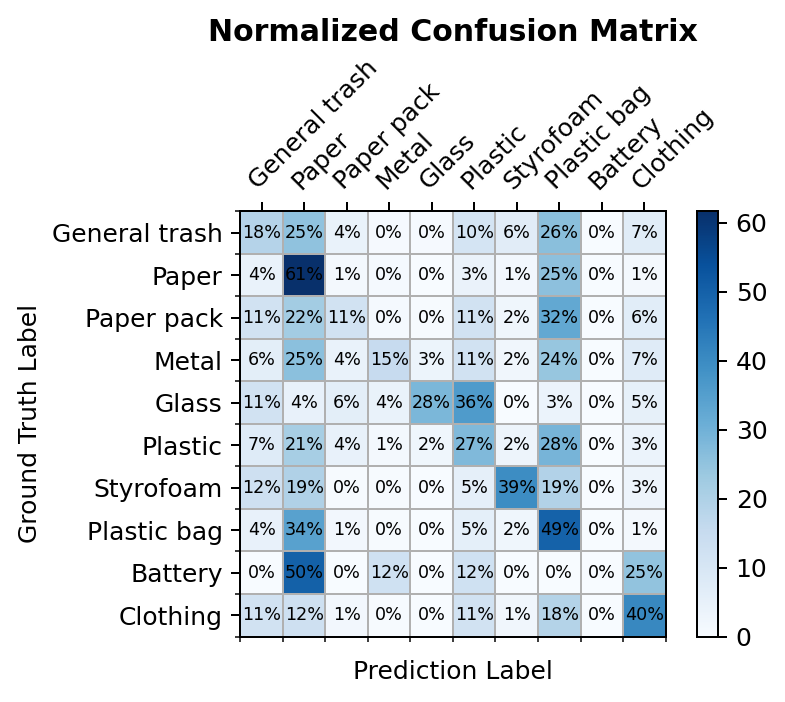

In [65]:
assert isinstance(results, list)
if isinstance(results[0], list):
    pass
elif isinstance(results[0], tuple):
    results = [result[0] for result in results]
else:
    raise TypeError('invalid type of prediction results')

if isinstance(cfg.data.test, dict):
    cfg.data.test.test_mode = True
elif isinstance(cfg.data.test, list):
    for ds_cfg in cfg.data.test:
        ds_cfg.test_mode = True
dataset = build_dataset(cfg.data.test)

# Bbox의 score threshold 설정
score_thr = 0.0

# IoU threshold to be considered as matched.
# NMS threshold는 이미 test_cfg에서 0.5로 설정해 두었으므로
# None 고정
nms_iou_thr = None

# tp_iou_thr 이상인 bbox에 대해서만 confusion matrix를 계산
# 예측 값들에 대해 전부 confusion matrix를 계산하기 위해 0.0
tp_iou_thr = 0.0

confusion_matrix = calculate_confusion_matrix(dataset, results,
                                              score_thr,
                                              nms_iou_thr,
                                              tp_iou_thr)

# Actual을 전부 더했을 때 100%가 안나올 수 있음(float형을 int형으로 바꾸면서 내림)
plot_confusion_matrix(
    confusion_matrix,
    dataset.CLASSES,
    save_dir=None,
    show=True,
    color_theme='Blues')

## PR Curve

### 필요한 정보들 입력

In [191]:
config_name = 'FasterRCNN_V3_config.py'
config_path = '../[model]FasterRCNN_V3/FasterRCNN_V3_config.py'
checkpoint_path = '../[model]FasterRCNN_V3/checkpoint/latest.pth'
train_annot_path = 'train2_swj.json'
val_annot_path = 'val2_swj.json'

cfg = Config.fromfile(config_path)

data_root = '../../../../../../dataset/'

cfg.data.train.dataset.img_prefix = data_root
cfg.data.train.dataset.ann_file = os.path.join(data_root, train_annot_path)
cfg.data.val.img_prefix = data_root
cfg.data.val.ann_file = os.path.join(data_root, val_annot_path)
cfg.data.test.img_prefix = data_root
cfg.data.test.ann_file = os.path.join(data_root, val_annot_path)

# Score threshold는 0.0으로 설정하고 confusion matrix를 그릴때 다시 설정
cfg.model.test_cfg.rcnn.score_thr = 0.5

### Validation dataset 불러오기

In [27]:
# Dataset
class Dataset:
    def __init__(self, data_dir="../../../dataset", json_file="train.json"):
        """
        annotation: annotation 파일 위치
        data_dir: data가 존재하는 폴더 경로
        category_id: ["General trash", "Paper", "Paper pack", "Metal", "Glass",
                        "Plastic", "Styrofoam", "Plastic bag", "Battery", "Clothing"]
        """

        super().__init__()
        self.data_dir = data_dir
        self.annotation = os.path.join(self.data_dir, json_file)

        info = []
        # coco annotation 불러오기 (coco API)
        self.coco = COCO(self.annotation)
        for image_id in self.coco.getImgIds():
            image_info = self.coco.loadImgs(image_id)[0]
            annotation_id = self.coco.getAnnIds(imgIds=image_info["id"])
            annotation_info_list = self.coco.loadAnns(annotation_id)

            file_name = os.path.join(self.data_dir, image_info["file_name"])

            # [x_min, x_max, y_min, y_max]
            for annotation in annotation_info_list:
                info.append(
                    [
                        image_id,
                        file_name,
                        int(annotation["category_id"]),
                        float(annotation["bbox"][0]),
                        float(annotation["bbox"][0]) + float(annotation["bbox"][2]),
                        float(annotation["bbox"][1]),
                        (float(annotation["bbox"][1]) + float(annotation["bbox"][3])),
                        float(annotation["bbox"][2]),
                        float(annotation["bbox"][3]),
                        float(annotation["area"]),
                    ]
                )

        self.df = pd.DataFrame(
            info,
            columns=[
                "img_id",
                "img_path",
                "label",
                "x_min",
                "x_max",
                "y_min",
                "y_max",
                "width",
                "height",
                "area",
            ],
        )

        self.df["center_x"] = (self.df["x_max"] + self.df["x_min"]) / 2
        self.df["center_y"] = (self.df["y_max"] + self.df["y_min"]) / 2
        
        
    def grouping_bbox_per_img(self):
        """
        Using Example:
            eda = EDADataset()
            img_df, img_df_idx = eda.grouping_bbox_per_img()
            eda.df.iloc[img_df_idx[1]] -> 하나의 이미지에 있는 bbox의 정보를 나타냄
        Return:
            Return group index (dict type)
        """
        group_df = self.df.groupby("img_id")
        return group_df, group_df.groups

In [30]:
dataset = Dataset(data_dir=data_root, json_file=val_annot_path)
df = dataset.df
_, img_df_idx = dataset.grouping_bbox_per_img()

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


### Validation Dataset에 대해 Prediction

⚠️ 시간이 소요될 수 있습니다!!

In [ ]:
# replace the ${key} with the value of cfg.key
cfg = replace_cfg_vals(cfg)

# update data root according to MMDET_DATASETS
update_data_root(cfg)

cfg = compat_cfg(cfg)

# set multi-process settings
setup_multi_processes(cfg)

# set cudnn_benchmark
if cfg.get('cudnn_benchmark', False):
    torch.backends.cudnn.benchmark = True

if 'pretrained' in cfg.model:
    cfg.model.pretrained = None
elif 'init_cfg' in cfg.model.backbone:
    cfg.model.backbone.init_cfg = None

if cfg.model.get('neck'):
    if isinstance(cfg.model.neck, list):
        for neck_cfg in cfg.model.neck:
            if neck_cfg.get('rfp_backbone'):
                if neck_cfg.rfp_backbone.get('pretrained'):
                    neck_cfg.rfp_backbone.pretrained = None
    elif cfg.model.neck.get('rfp_backbone'):
        if cfg.model.neck.rfp_backbone.get('pretrained'):
            cfg.model.neck.rfp_backbone.pretrained = None

cfg.gpu_ids = [0]
cfg.device = get_device()
# init distributed env first, since logger depends on the dist info.
distributed = False

test_dataloader_default_args = dict(
    samples_per_gpu=1, workers_per_gpu=2, dist=distributed, shuffle=False)

# in case the test dataset is concatenated
if isinstance(cfg.data.test, dict):
    cfg.data.test.test_mode = True
    if cfg.data.test_dataloader.get('samples_per_gpu', 1) > 1:
        # Replace 'ImageToTensor' to 'DefaultFormatBundle'
        cfg.data.test.pipeline = replace_ImageToTensor(
            cfg.data.test.pipeline)
elif isinstance(cfg.data.test, list):
    for ds_cfg in cfg.data.test:
        ds_cfg.test_mode = True
    if cfg.data.test_dataloader.get('samples_per_gpu', 1) > 1:
        for ds_cfg in cfg.data.test:
            ds_cfg.pipeline = replace_ImageToTensor(ds_cfg.pipeline)

test_loader_cfg = {
    **test_dataloader_default_args,
    **cfg.data.get('test_dataloader', {})
}

rank, _ = get_dist_info()
        
# build the dataloade
dataset = build_dataset(cfg.data.test)
data_loader = build_dataloader(dataset, **test_loader_cfg)

# build the model and load checkpoint
cfg.model.train_cfg = None
model = build_detector(cfg.model, test_cfg=cfg.get('test_cfg'))
fp16_cfg = cfg.get('fp16', None)
if fp16_cfg is not None:
    wrap_fp16_model(model)
checkpoint = load_checkpoint(model, checkpoint_path, map_location='cpu')

# old versions did not save class info in checkpoints, this walkaround is
# for backward compatibility
if 'CLASSES' in checkpoint.get('meta', {}):
    model.CLASSES = checkpoint['meta']['CLASSES']
else:
    model.CLASSES = dataset.CLASSES

model = build_dp(model, cfg.device, device_ids=cfg.gpu_ids)
results = single_gpu_test(model, data_loader, False, None, 0.5)

### Prediction 결과 COCO Format으로 변환

In [53]:
with open(os.path.join(data_root, val_annot_path), "rt", encoding="UTF-8") as annot_path:
    coco = json.load(annot_path)

ann_cnt = 0
images, annotations = [], []
for i, key in enumerate(tqdm(sorted(img_df_idx))):
    result = results[i]
    for j, res in enumerate(result):
        if len(res) > 0:
            for bbox in res:
                ann_dict = {
                    "image_id": key,
                    "category_id": j,
                    "area": (bbox[2]-bbox[0])*(bbox[3]-bbox[1]),
                    "bbox": [
                        bbox[0],
                        bbox[1],
                        bbox[2]-bbox[0],
                        bbox[3]-bbox[1]
                    ],
                    "score":bbox[4],
                    "iscrowd":0,
                    "id":ann_cnt
                }
                ann_cnt += 1
    annotations.append(ann_dict)

688it [00:00, 47733.50it/s]


In [55]:
def makeplot(rs, ps, outDir, class_name, iou_type):
    cs = np.vstack([
        np.ones((2, 3)),
        np.array([0.31, 0.51, 0.74]),
        np.array([0.75, 0.31, 0.30]),
        np.array([0.36, 0.90, 0.38]),
        np.array([0.50, 0.39, 0.64]),
        np.array([1, 0.6, 0]),
    ])
    areaNames = ['allarea', 'small', 'medium', 'large']
    types = ['C75', 'C50', 'Loc', 'Sim', 'Oth', 'BG', 'FN']
    for i in range(len(areaNames)):
        area_ps = ps[..., i, 0]
        figure_title = iou_type + '-' + class_name + '-' + areaNames[i]
        aps = [ps_.mean() for ps_ in area_ps]
        ps_curve = [
            ps_.mean(axis=1) if ps_.ndim > 1 else ps_ for ps_ in area_ps
        ]
        ps_curve.insert(0, np.zeros(ps_curve[0].shape))
        fig = plt.figure()
        ax = plt.subplot(111)
        for k in range(len(types)):
            ax.plot(rs, ps_curve[k + 1], color=[0, 0, 0], linewidth=0.5)
            ax.fill_between(
                rs,
                ps_curve[k],
                ps_curve[k + 1],
                color=cs[k],
                label=str(f'[{aps[k]:.3f}]' + types[k]),
            )
        plt.xlabel('recall')
        plt.ylabel('precision')
        plt.xlim(0, 1.0)
        plt.ylim(0, 1.0)
        plt.title(figure_title)
        plt.legend()
        # plt.show()
        fig.savefig(outDir + f'/{figure_title}.png')
        plt.close(fig)


def autolabel(ax, rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        if height > 0 and height <= 1:  # for percent values
            text_label = '{:2.0f}'.format(height * 100)
        else:
            text_label = '{:2.0f}'.format(height)
        ax.annotate(
            text_label,
            xy=(rect.get_x() + rect.get_width() / 2, height),
            xytext=(0, 3),  # 3 points vertical offset
            textcoords='offset points',
            ha='center',
            va='bottom',
            fontsize='x-small',
        )


def makebarplot(rs, ps, outDir, class_name, iou_type):
    areaNames = ['allarea', 'small', 'medium', 'large']
    types = ['C75', 'C50', 'Loc', 'Sim', 'Oth', 'BG', 'FN']
    fig, ax = plt.subplots()
    x = np.arange(len(areaNames))  # the areaNames locations
    width = 0.60  # the width of the bars
    rects_list = []
    figure_title = iou_type + '-' + class_name + '-' + 'ap bar plot'
    for i in range(len(types) - 1):
        type_ps = ps[i, ..., 0]
        aps = [ps_.mean() for ps_ in type_ps.T]
        rects_list.append(
            ax.bar(
                x - width / 2 + (i + 1) * width / len(types),
                aps,
                width / len(types),
                label=types[i],
            ))

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Mean Average Precision (mAP)')
    ax.set_title(figure_title)
    ax.set_xticks(x)
    ax.set_xticklabels(areaNames)
    ax.legend()

    # Add score texts over bars
    for rects in rects_list:
        autolabel(ax, rects)

    # Save plot
    fig.savefig(outDir + f'/{figure_title}.png')
    plt.close(fig)


def get_gt_area_group_numbers(cocoEval):
    areaRng = cocoEval.params.areaRng
    areaRngStr = [str(aRng) for aRng in areaRng]
    areaRngLbl = cocoEval.params.areaRngLbl
    areaRngStr2areaRngLbl = dict(zip(areaRngStr, areaRngLbl))
    areaRngLbl2Number = dict.fromkeys(areaRngLbl, 0)
    for evalImg in cocoEval.evalImgs:
        if evalImg:
            for gtIgnore in evalImg['gtIgnore']:
                if not gtIgnore:
                    aRngLbl = areaRngStr2areaRngLbl[str(evalImg['aRng'])]
                    areaRngLbl2Number[aRngLbl] += 1
    return areaRngLbl2Number


def make_gt_area_group_numbers_plot(cocoEval, outDir, verbose=True):
    areaRngLbl2Number = get_gt_area_group_numbers(cocoEval)
    areaRngLbl = areaRngLbl2Number.keys()
    if verbose:
        print('number of annotations per area group:', areaRngLbl2Number)

    # Init figure
    fig, ax = plt.subplots()
    x = np.arange(len(areaRngLbl))  # the areaNames locations
    width = 0.60  # the width of the bars
    figure_title = 'number of annotations per area group'

    rects = ax.bar(x, areaRngLbl2Number.values(), width)

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Number of annotations')
    ax.set_title(figure_title)
    ax.set_xticks(x)
    ax.set_xticklabels(areaRngLbl)

    # Add score texts over bars
    autolabel(ax, rects)

    # Save plot
    fig.tight_layout()
    fig.savefig(outDir + f'/{figure_title}.png')
    plt.close(fig)


def make_gt_area_histogram_plot(cocoEval, outDir):
    n_bins = 100
    areas = [ann['area'] for ann in cocoEval.cocoGt.anns.values()]

    # init figure
    figure_title = 'gt annotation areas histogram plot'
    fig, ax = plt.subplots()

    # Set the number of bins
    ax.hist(np.sqrt(areas), bins=n_bins)

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_xlabel('Squareroot Area')
    ax.set_ylabel('Number of annotations')
    ax.set_title(figure_title)

    # Save plot
    fig.tight_layout()
    fig.savefig(outDir + f'/{figure_title}.png')
    plt.close(fig)

def analyze_individual_category(k,
                                cocoDt,
                                cocoGt,
                                catId,
                                iou_type,
                                areas=None):
    nm = cocoGt.loadCats(catId)[0]
    print(f'--------------analyzing {k + 1}-{nm["name"]}---------------')
    ps_ = {}
    dt = copy.deepcopy(cocoDt)
    nm = cocoGt.loadCats(catId)[0]
    imgIds = cocoGt.getImgIds()
    dt_anns = dt.dataset['annotations']
    select_dt_anns = []
    for ann in dt_anns:
        if ann['category_id'] == catId:
            select_dt_anns.append(ann)
    dt.dataset['annotations'] = select_dt_anns
    dt.createIndex()
    # compute precision but ignore superclass confusion
    gt = copy.deepcopy(cocoGt)
    child_catIds = gt.getCatIds(supNms=[nm['supercategory']])
    for idx, ann in enumerate(gt.dataset['annotations']):
        if ann['category_id'] in child_catIds and ann['category_id'] != catId:
            gt.dataset['annotations'][idx]['ignore'] = 1
            gt.dataset['annotations'][idx]['iscrowd'] = 1
            gt.dataset['annotations'][idx]['category_id'] = catId
    cocoEval = COCOeval(gt, copy.deepcopy(dt), iou_type)
    cocoEval.params.imgIds = imgIds
    cocoEval.params.maxDets = [100]
    cocoEval.params.iouThrs = [0.1]
    cocoEval.params.useCats = 1
    if areas:
        cocoEval.params.areaRng = [[0**2, areas[2]], [0**2, areas[0]],
                                   [areas[0], areas[1]], [areas[1], areas[2]]]
    cocoEval.evaluate()
    cocoEval.accumulate()
    ps_supercategory = cocoEval.eval['precision'][0, :, k, :, :]
    ps_['ps_supercategory'] = ps_supercategory
    # compute precision but ignore any class confusion
    gt = copy.deepcopy(cocoGt)
    for idx, ann in enumerate(gt.dataset['annotations']):
        if ann['category_id'] != catId:
            gt.dataset['annotations'][idx]['ignore'] = 1
            gt.dataset['annotations'][idx]['iscrowd'] = 1
            gt.dataset['annotations'][idx]['category_id'] = catId
    cocoEval = COCOeval(gt, copy.deepcopy(dt), iou_type)
    cocoEval.params.imgIds = imgIds
    cocoEval.params.maxDets = [100]
    cocoEval.params.iouThrs = [0.1]
    cocoEval.params.useCats = 1
    if areas:
        cocoEval.params.areaRng = [[0**2, areas[2]], [0**2, areas[0]],
                                   [areas[0], areas[1]], [areas[1], areas[2]]]
    cocoEval.evaluate()
    cocoEval.accumulate()
    ps_allcategory = cocoEval.eval['precision'][0, :, k, :, :]
    ps_['ps_allcategory'] = ps_allcategory
    return k, ps_

def analyze_results(res_file,
                    ann_file,
                    res_types,
                    out_dir,
                    extraplots=None,
                    areas=None):
    for res_type in res_types:
        assert res_type in ['bbox', 'segm']
    if areas:
        assert len(areas) == 3, '3 integers should be specified as areas, \
            representing 3 area regions'

    directory = os.path.dirname(out_dir + '/')
    if not os.path.exists(directory):
        print(f'-------------create {out_dir}-----------------')
        os.makedirs(directory)

    cocoGt = COCO(ann_file)
    cocoDt = cocoGt.loadRes(res_file)
    imgIds = cocoGt.getImgIds()
    for res_type in res_types:
        res_out_dir = out_dir + '/' + res_type + '/'
        res_directory = os.path.dirname(res_out_dir)
        if not os.path.exists(res_directory):
            print(f'-------------create {res_out_dir}-----------------')
            os.makedirs(res_directory)
        iou_type = res_type
        cocoEval = COCOeval(
            copy.deepcopy(cocoGt), copy.deepcopy(cocoDt), iou_type)
        cocoEval.params.imgIds = imgIds
        cocoEval.params.iouThrs = [0.75, 0.5, 0.1]
        cocoEval.params.maxDets = [100]
        if areas:
            cocoEval.params.areaRng = [[0**2, areas[2]], [0**2, areas[0]],
                                       [areas[0], areas[1]],
                                       [areas[1], areas[2]]]
        cocoEval.evaluate()
        cocoEval.accumulate()
        ps = cocoEval.eval['precision']
        ps = np.vstack([ps, np.zeros((4, *ps.shape[1:]))])
        catIds = cocoGt.getCatIds()
        recThrs = cocoEval.params.recThrs
        with Pool(processes=48) as pool:
            args = [(k, cocoDt, cocoGt, catId, iou_type, areas)
                    for k, catId in enumerate(catIds)]
            analyze_results = pool.starmap(analyze_individual_category, args)
        for k, catId in enumerate(catIds):
            nm = cocoGt.loadCats(catId)[0]
            print(f'--------------saving {k + 1}-{nm["name"]}---------------')
            analyze_result = analyze_results[k]
            assert k == analyze_result[0]
            ps_supercategory = analyze_result[1]['ps_supercategory']
            ps_allcategory = analyze_result[1]['ps_allcategory']
            # compute precision but ignore superclass confusion
            ps[3, :, k, :, :] = ps_supercategory
            # compute precision but ignore any class confusion
            ps[4, :, k, :, :] = ps_allcategory
            # fill in background and false negative errors and plot
            ps[ps == -1] = 0
            ps[5, :, k, :, :] = ps[4, :, k, :, :] > 0
            ps[6, :, k, :, :] = 1.0
            makeplot(recThrs, ps[:, :, k], res_out_dir, nm['name'], iou_type)
            if extraplots:
                makebarplot(recThrs, ps[:, :, k], res_out_dir, nm['name'],
                            iou_type)
        makeplot(recThrs, ps, res_out_dir, 'allclass', iou_type)
        if extraplots:
            makebarplot(recThrs, ps, res_out_dir, 'allclass', iou_type)
            make_gt_area_group_numbers_plot(
                cocoEval=cocoEval, outDir=res_out_dir, verbose=True)
            make_gt_area_histogram_plot(cocoEval=cocoEval, outDir=res_out_dir)

In [54]:
analyze_results(
    res_file=annotations,
    ann_file=os.path.join(data_root, val_annot_path),
    res_types=['bbox'],
    out_dir='./',
    extraplots=True,
    areas=[32*32, 64*64, 1024*1024])

loading annotations into memory...
Done (t=0.16s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.27s).
Accumulating evaluation results...
DONE (t=0.03s).
--------------analyzing 1-General trash---------------
--------------analyzing 2-Paper---------------
--------------analyzing 3-Paper pack---------------
creating index...
index created!
--------------analyzing 4-Metal---------------creating index...

index created!creating index...--------------analyzing 5-Glass---------------

index created!

--------------analyzing 6-Plastic---------------
creating index...
index created!
--------------analyzing 7-Styrofoam---------------creating index...

index created!
--------------analyzing 9-Battery---------------Running per image evaluation...

Evaluate annotation type *bbox*
Running per image evaluation...Running per image evaluation...creating index...

## Bounding Box 확인

### 필요한 함수들 정의

In [180]:
def init_detector(config, checkpoint=None, device='cuda:0', cfg_options=None):
    """Initialize a detector from config file.

    Args:
        config (str, :obj:`Path`, or :obj:`mmcv.Config`): Config file path,
            :obj:`Path`, or the config object.
        checkpoint (str, optional): Checkpoint path. If left as None, the model
            will not load any weights.
        cfg_options (dict): Options to override some settings in the used
            config.

    Returns:
        nn.Module: The constructed detector.
    """
    # if isinstance(config, (str, Path)):
    #     config = mmcv.Config.fromfile(config)
    # elif not isinstance(config, mmcv.Config):
    #     raise TypeError('config must be a filename or Config object, '
    #                     f'but got {type(config)}')
    if cfg_options is not None:
        config.merge_from_dict(cfg_options)
    if 'pretrained' in config.model:
        config.model.pretrained = None
    elif 'init_cfg' in config.model.backbone:
        config.model.backbone.init_cfg = None
    config.model.train_cfg = None
    model = build_detector(config.model, test_cfg=config.get('test_cfg'))
    if checkpoint is not None:
        checkpoint = load_checkpoint(model, checkpoint, map_location='cpu')
        if 'CLASSES' in checkpoint.get('meta', {}):
            model.CLASSES = checkpoint['meta']['CLASSES']
        else:
            warnings.simplefilter('once')
            warnings.warn('Class names are not saved in the checkpoint\'s '
                          'meta data, use COCO classes by default.')
            model.CLASSES = get_classes('coco')
    model.cfg = config  # save the config in the model for convenience
    model.to(device)
    model.eval()
    return model

def get_result_gt(df):
    img_result = [[] for _ in range(10)]
    for i in range(len(df)):
        line = df.iloc[i]
        img_result[int(line['label'])].append([line['x_min'], line['y_min'], line['x_max'], line['y_max'], 1.0])
    return img_result

def show_result(img_path, results, class_names, colors, score_thr=0.5):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.copy()
    for idx, result in enumerate(results):
        for res in result:
            score = res[4]
            if score_thr < score:
                x_min, y_min, x_max, y_max = map(int, res[:4])
                class_name = class_names[idx]
                color = colors[idx]
                img = cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color, 3)
                text_size, _ = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 1, 2)
                text_x = text_size[0]
                text_y = text_size[1]
                img = cv2.rectangle(img, (x_min, y_min), (x_min + text_size[0], y_min + text_y), (0,0,0), -1)
                img = cv2.putText(img, class_name, (x_min, y_min + text_y), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    return img

def small_bbox(result1, result2, lower, upper, score_thr):
    """
    Args:
        result1: result_gt
        result2: result_pred
    """
    pred_, gt_ = [], []
    pred_check, gt_check = False, False
    for idx, (res_gt, res_pred) in enumerate(zip(result1, result2)):
        pred_bbox, gt_bbox = [], []
        for res in res_gt:
            x_min, y_min, x_max, y_max, score = res
            if lower <= (x_max-x_min)*(y_max-y_min) < upper and score_thr < score:
                gt_bbox.append(res)
                gt_check=True
        for res in res_pred:
            x_min, y_min, x_max, y_max, score = res
            if lower <= (x_max-x_min)*(y_max-y_min) < upper and score_thr < score:
                pred_bbox.append(res)
                pred_check=True
        gt_.append(gt_bbox)
        pred_.append(pred_bbox)
    return gt_, pred_, gt_check, pred_check

### Validation Dataset 불러오기

In [58]:
# Dataset
class Dataset:
    def __init__(self, data_dir="../../../dataset", json_file="train.json"):
        """
        annotation: annotation 파일 위치
        data_dir: data가 존재하는 폴더 경로
        category_id: ["General trash", "Paper", "Paper pack", "Metal", "Glass",
                        "Plastic", "Styrofoam", "Plastic bag", "Battery", "Clothing"]
        """

        super().__init__()
        self.data_dir = data_dir
        self.annotation = os.path.join(self.data_dir, json_file)

        info = []
        # coco annotation 불러오기 (coco API)
        self.coco = COCO(self.annotation)
        for image_id in self.coco.getImgIds():
            image_info = self.coco.loadImgs(image_id)[0]
            annotation_id = self.coco.getAnnIds(imgIds=image_info["id"])
            annotation_info_list = self.coco.loadAnns(annotation_id)

            file_name = os.path.join(self.data_dir, image_info["file_name"])

            # [x_min, x_max, y_min, y_max]
            for annotation in annotation_info_list:
                info.append(
                    [
                        image_id,
                        file_name,
                        int(annotation["category_id"]),
                        float(annotation["bbox"][0]),
                        float(annotation["bbox"][0]) + float(annotation["bbox"][2]),
                        float(annotation["bbox"][1]),
                        (float(annotation["bbox"][1]) + float(annotation["bbox"][3])),
                        float(annotation["bbox"][2]),
                        float(annotation["bbox"][3]),
                        float(annotation["area"]),
                    ]
                )

        self.df = pd.DataFrame(
            info,
            columns=[
                "img_id",
                "img_path",
                "label",
                "x_min",
                "x_max",
                "y_min",
                "y_max",
                "width",
                "height",
                "area",
            ],
        )

        self.df["center_x"] = (self.df["x_max"] + self.df["x_min"]) / 2
        self.df["center_y"] = (self.df["y_max"] + self.df["y_min"]) / 2
        
        
    def grouping_bbox_per_img(self):
        """
        Using Example:
            eda = EDADataset()
            img_df, img_df_idx = eda.grouping_bbox_per_img()
            eda.df.iloc[img_df_idx[1]] -> 하나의 이미지에 있는 bbox의 정보를 나타냄
        Return:
            Return group index (dict type)
        """
        group_df = self.df.groupby("img_id")
        return group_df, group_df.groups

In [59]:
dataset = Dataset(data_dir=data_root, json_file='val2_swj.json')
df = dataset.df
_, img_df_idx = dataset.grouping_bbox_per_img()

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


### 필요한 정보들 입력

In [67]:
config_path = '../[model]FasterRCNN_V3/FasterRCNN_V3_config.py'
checkpoint_path = '../[model]FasterRCNN_V3/checkpoint/latest.pth'

cfg = Config.fromfile(config_path)

data_root = '../../../../../../dataset/'

cfg.data.train.dataset.img_prefix = data_root
cfg.data.train.dataset.ann_file = os.path.join(data_root, 'train2_swj.json')
cfg.data.val.img_prefix = data_root
cfg.data.val.ann_file = os.path.join(data_root, 'val2_swj.json')
cfg.data.test.img_prefix = data_root
cfg.data.test.ann_file = os.path.join(data_root, 'val2_swj.json')

### Model import

In [68]:
model = init_detector(cfg, checkpoint=checkpoint_path)

load checkpoint from local path: ../[model]FasterRCNN_V3/checkpoint/latest.pth


### Class와 color 정의

In [69]:
class_names = [
    "General trash",
    "Paper",
    "Paper pack",
    "Metal",
    "Glass",
    "Plastic",
    "Styrofoam",
    "Plastic bag",
    "Battery",
    "Clothing",]
colors = [(251, 76, 81),
          (251, 76, 195),
          (158, 76, 251),
          (76, 97, 251),
          (76, 190, 251),
          (76, 251, 217),
          (76, 251, 126),
          (251, 251, 76),
          (251, 195, 76),
          (251, 129, 76)]

### Bounding Box 그리기

#### 10개 무작위로 뽑아서 살펴보기

In [ ]:
for key in random.sample(list(img_df_idx.keys()), 10):
    img_df = df.iloc[img_df_idx[key]].reset_index()
    path_ = img_df['img_path'].iloc[0].split('/')
    img_path = os.path.join(data_root, path_[-2], path_[-1])
    result_pred = inference_detector(model, img_path)
    result_gt = get_result_gt(img_df)
    img_pred = show_result(img_path, result_pred, class_names, colors, score_thr=0.5)
    img_gt = show_result(img_path, result_gt, class_names, colors, score_thr=0.0)
    line = np.ones((1024,30,3), dtype='uint8')*255
    img = np.concatenate((img_gt, line, img_pred), axis=1)
    plt.imshow(img)
    plt.title('Ground Truth VS Prediction')
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    if i == 10:
        break

#### 하나의 Image 살펴보기

- 살펴볼 수 있는 Image 번호 알아보기

In [90]:
print(img_df_idx.keys())

dict_keys([0, 2, 5, 30, 33, 47, 48, 51, 63, 79, 82, 84, 95, 104, 115, 125, 135, 137, 139, 146, 148, 149, 157, 158, 166, 171, 180, 190, 191, 195, 196, 202, 219, 242, 244, 254, 255, 279, 288, 297, 302, 318, 322, 328, 330, 332, 346, 367, 374, 375, 382, 390, 397, 401, 410, 412, 420, 425, 434, 435, 443, 454, 458, 470, 484, 497, 505, 509, 525, 529, 535, 548, 565, 570, 580, 584, 586, 589, 595, 597, 602, 633, 634, 645, 672, 676, 684, 689, 701, 725, 729, 733, 766, 776, 779, 806, 815, 819, 827, 828, 846, 850, 851, 852, 857, 886, 890, 905, 917, 920, 926, 931, 946, 957, 990, 994, 1000, 1001, 1003, 1029, 1038, 1041, 1054, 1055, 1063, 1072, 1073, 1094, 1099, 1102, 1103, 1105, 1124, 1136, 1140, 1141, 1151, 1154, 1161, 1164, 1176, 1179, 1181, 1211, 1234, 1240, 1244, 1253, 1256, 1261, 1271, 1274, 1278, 1281, 1283, 1301, 1327, 1330, 1332, 1342, 1344, 1348, 1352, 1354, 1364, 1368, 1369, 1370, 1389, 1417, 1425, 1426, 1427, 1454, 1473, 1475, 1483, 1486, 1500, 1505, 1521, 1537, 1538, 1549, 1550, 1556, 1566,

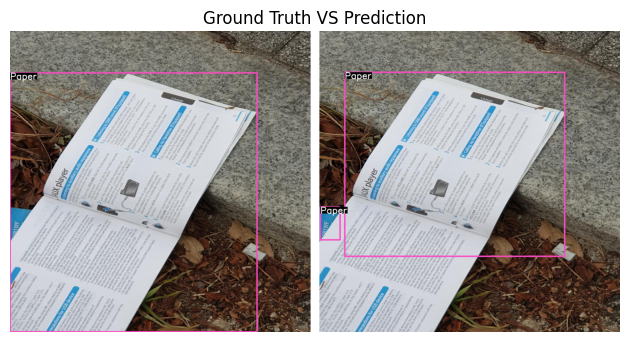

In [91]:
key = 95
img_df = df.iloc[img_df_idx[key]].reset_index()
path_ = img_df['img_path'].iloc[0].split('/')
img_path = os.path.join(data_root, path_[-2], path_[-1])
result_pred = inference_detector(model, img_path)
result_gt = get_result_gt(img_df)
img_pred = show_result(img_path, result_pred, class_names, colors, score_thr=0.5)
img_gt = show_result(img_path, result_gt, class_names, colors, score_thr=0.0)
line = np.ones((1024,30,3), dtype='uint8')*255
img = np.concatenate((img_gt, line, img_pred), axis=1)
plt.imshow(img)
plt.title('Ground Truth VS Prediction')
plt.axis('off')
plt.tight_layout()
plt.show()

#### Bounding box가 하나도 안그려지는 Image 확인

⚠️ 시간이 소요될 수 있습니다!!

In [ ]:
no_show = []
for key in tqdm(sorted(img_df_idx)):
    img_df = df.iloc[img_df_idx[key]].reset_index()
    path_ = img_df['img_path'].iloc[0].split('/')
    img_path = os.path.join(data_root, path_[-2], path_[-1])
    result_pred = inference_detector(model, img_path)
    check = True
    for bbox in result_pred:
        if len(bbox) > 0:
            check = False
            break
    if check:
        no_show.append(key)
print(f'Bounding Box가 하나도 없는 Image 개수 >> {len(no_show)}')

- Bounding Box가 하나도 없는 Image 확인하기

In [ ]:
for key in no_show:
    img_df = df.iloc[img_df_idx[key]].reset_index()
    path_ = img_df['img_path'].iloc[0].split('/')
    img_path = os.path.join(data_root, path_[-2], path_[-1])
    result_pred = inference_detector(model, img_path)
    result_gt = get_result_gt(img_df)
    img_pred = show_result(img_path, result_pred, class_names, colors, score_thr=0.5)
    img_gt = show_result(img_path, result_gt, class_names, colors, score_thr=0.0)
    line = np.ones((1024,30,3), dtype='uint8')*255
    img = np.concatenate((img_gt, line, img_pred), axis=1)
    plt.imshow(img)
    plt.title('Ground Truth VS Prediction')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

#### 특정 크기의 Bounding box들은 잘 잡는지 확인

⚠️ 시간이 소요될 수 있습니다!!

In [205]:
both, gt, pred = {}, {}, {}
lower, upper = 0, 32
score_thr = 0.5
for idx, key in enumerate(tqdm(sorted(img_df_idx))):
    img_df = df.iloc[img_df_idx[key]].reset_index()
    path_ = img_df['img_path'].iloc[0].split('/')
    img_path = os.path.join(data_root, path_[-2], path_[-1])
    result_pred = inference_detector(model, img_path)
    result_gt = get_result_gt(img_df)
    small_gt, small_pred, gt_check, pred_check = small_bbox(result_gt, result_pred, lower**2, upper**2, score_thr)
    if not (gt_check or pred_check):
        continue
    if gt_check and pred_check:
        both[key] = [small_gt, small_pred]
    elif gt_check:
        gt[key] = [small_gt, small_pred]
    else:
        pred[key] = [small_gt, small_pred]

100%|██████████| 688/688 [04:07<00:00,  2.78it/s]


In [206]:
print(f'{lower}*{lower} <= bounding box의 size < {upper}*{upper}에 해당되는 bounding box가 Ground Truth, Prediction에 모두 있는 경우\n{len(both)}개 >> {list(both.keys())}\n')
print(f'{lower}*{lower} <= bounding box의 size < {upper}*{upper}에 해당되는 bounding box가 Ground Truth에만 있는 경우\n{len(gt)}개 >> {list(gt.keys())}\n')
print(f'{lower}*{lower} <= bounding box의 size < {upper}*{upper}에 해당되는 bounding box가 Prediction에만 있는 경우\n{len(pred)}개 >> {list(pred.keys())}\n')

0*0 <= bounding box의 size < 32*32에 해당되는 bounding box가 Ground Truth, Prediction에 모두 있는 경우
1개 >> [1521]

0*0 <= bounding box의 size < 32*32에 해당되는 bounding box가 Ground Truth에만 있는 경우
74개 >> [5, 51, 190, 443, 602, 684, 806, 819, 850, 946, 1063, 1161, 1244, 1283, 1370, 1389, 1417, 1426, 1473, 1486, 1645, 1700, 1913, 1918, 1981, 2133, 2169, 2182, 2345, 2349, 2451, 2482, 2553, 2562, 2630, 2647, 2724, 2743, 2760, 2912, 2932, 2956, 3005, 3046, 3055, 3115, 3128, 3150, 3211, 3225, 3245, 3275, 3356, 3373, 3395, 3515, 3657, 3697, 3712, 3818, 4047, 4062, 4146, 4197, 4313, 4414, 4456, 4708, 4766, 4771, 4778, 4813, 4814, 4859]

0*0 <= bounding box의 size < 32*32에 해당되는 bounding box가 Prediction에만 있는 경우
0개 >> []



- `both`, `gt`, `pred` 중 하나 살펴보기

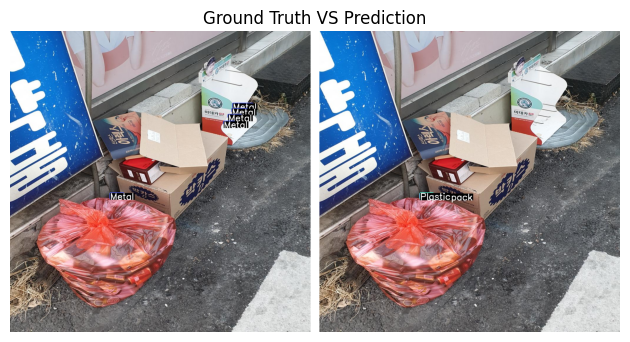

In [207]:
for key, (small_gt, small_pred) in both.items():
    img_df = df.iloc[img_df_idx[key]].reset_index()
    path_ = img_df['img_path'].iloc[0].split('/')
    img_path = os.path.join(data_root, path_[-2], path_[-1])
    img_pred = show_result(img_path, small_pred, class_names, colors, score_thr=score_thr)
    img_gt = show_result(img_path, small_gt, class_names, colors, score_thr=0.0)
    line = np.ones((1024,30,3), dtype='uint8')*255
    img = np.concatenate((img_gt, line, img_pred), axis=1)
    plt.imshow(img)
    plt.title('Ground Truth VS Prediction')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

- 원하는 이미지 살펴보기

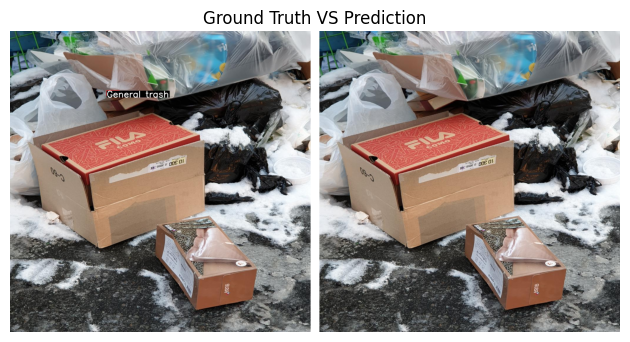

In [208]:
key = 5
small_gt, small_pred = gt[key]
img_df = df.iloc[img_df_idx[key]].reset_index()
path_ = img_df['img_path'].iloc[0].split('/')
img_path = os.path.join(data_root, path_[-2], path_[-1])
img_pred = show_result(img_path, small_pred, class_names, colors, score_thr=score_thr)
img_gt = show_result(img_path, small_gt, class_names, colors, score_thr=0.0)
line = np.ones((1024,30,3), dtype='uint8')*255
img = np.concatenate((img_gt, line, img_pred), axis=1)
plt.imshow(img)
plt.title('Ground Truth VS Prediction')
plt.axis('off')
plt.tight_layout()
plt.show()

#### 가장자리의 Bounding Box들 확인

In [209]:
def center_bbox(result1, result2, threshold, score_thr):
    """
    Args:
        result1: result_gt
        result2: result_pred
    """
    pred_, gt_ = [], []
    pred_check, gt_check = False, False
    for idx, (res_gt, res_pred) in enumerate(zip(result1, result2)):
        pred_bbox, gt_bbox = [], []
        for res in res_gt:
            x_min, y_min, x_max, y_max, score = res
            x_center, y_center = (x_max+x_min)/2, (y_max+y_min)/2
            if (threshold > x_center or 1024-threshold < x_center) and (threshold > y_center or 1024-threshold < y_center) and (score_thr < score):
                gt_bbox.append(res)
                gt_check=True
        for res in res_pred:
            x_min, y_min, x_max, y_max, score = res
            x_center, y_center = (x_max+x_min)/2, (y_max+y_min)/2
            if (threshold > x_center or 1024-threshold < x_center) and (threshold > y_center or 1024-threshold < y_center) and (score_thr < score):
                pred_bbox.append(res)
                pred_check=True
        gt_.append(gt_bbox)
        pred_.append(pred_bbox)
    return gt_, pred_, gt_check, pred_check

In [210]:
both, gt, pred = {}, {}, {}
threshold = 100 # 가장자리의 기준(ex. threshold=100 -> 0~100 & 1024-100~1024)
score_thr = 0.5
for idx, key in enumerate(tqdm(sorted(img_df_idx))):
    img_df = df.iloc[img_df_idx[key]].reset_index()
    path_ = img_df['img_path'].iloc[0].split('/')
    img_path = os.path.join(data_root, path_[-2], path_[-1])
    result_pred = inference_detector(model, img_path)
    result_gt = get_result_gt(img_df)
    center_gt, center_pred, gt_check, pred_check = center_bbox(result_gt, result_pred, threshold, score_thr)
    if not (gt_check or pred_check):
        continue
    if gt_check and pred_check:
        both[key] = [center_gt, center_pred]
    elif gt_check:
        gt[key] = [center_gt, center_pred]
    else:
        pred[key] = [center_gt, center_pred]

100%|██████████| 688/688 [04:03<00:00,  2.82it/s]


In [211]:
print(f'가장자리에 Bounding box의 Center Point가 위치하는 bounding box가 Ground Truth, Prediction에 모두 있는 경우\n{len(both)}개 >> {list(both.keys())}\n')
print(f'가장자리에 Bounding box의 Center Point가 위치하는 bounding box가 Ground Truth에만 있는 경우\n{len(gt)}개 >> {list(gt.keys())}\n')
print(f'가장자리에 Bounding box의 Center Point가 위치하는 bounding box가 Prediction에만 있는 경우\n{len(pred)}개 >> {list(pred.keys())}\n')

가장자리에 Bounding box의 Center Point가 위치하는 bounding box가 Ground Truth, Prediction에 모두 있는 경우
4개 >> [1161, 1417, 1700, 2647]

가장자리에 Bounding box의 Center Point가 위치하는 bounding box가 Ground Truth에만 있는 경우
4개 >> [5, 602, 1913, 3245]

가장자리에 Bounding box의 Center Point가 위치하는 bounding box가 Prediction에만 있는 경우
2개 >> [1918, 2700]



- `both`, `gt`, `pred` 중 하나 살펴보기

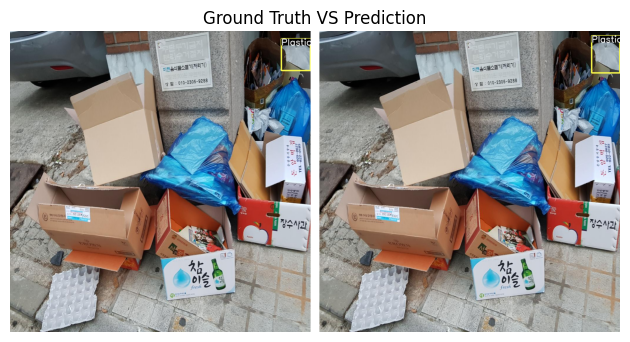

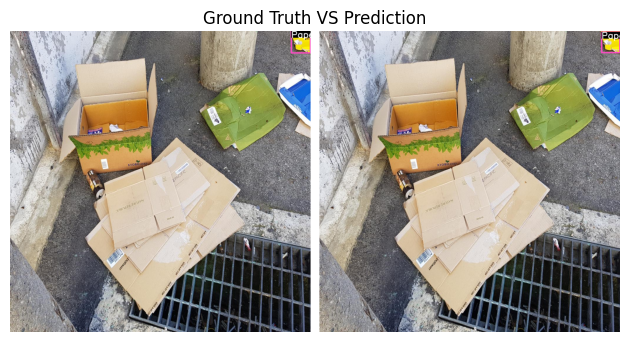

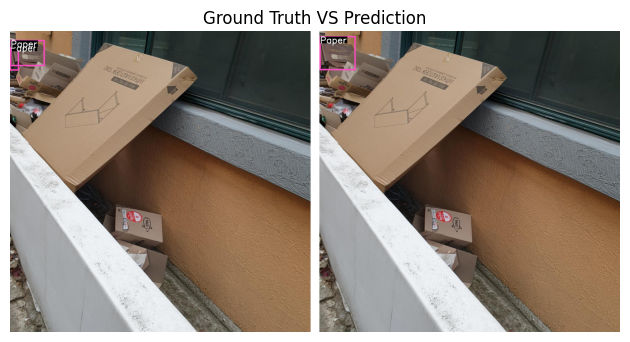

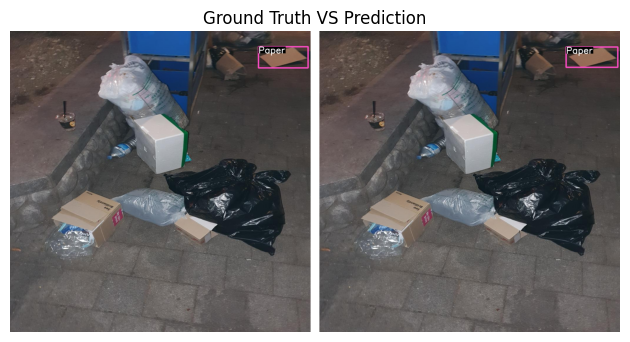

In [215]:
for key, (center_gt, center_pred) in both.items():
    img_df = df.iloc[img_df_idx[key]].reset_index()
    path_ = img_df['img_path'].iloc[0].split('/')
    img_path = os.path.join(data_root, path_[-2], path_[-1])
    img_pred = show_result(img_path, center_pred, class_names, colors, score_thr=score_thr)
    img_gt = show_result(img_path, center_gt, class_names, colors, score_thr=0.0)
    line = np.ones((1024,30,3), dtype='uint8')*255
    img = np.concatenate((img_gt, line, img_pred), axis=1)
    plt.imshow(img)
    plt.title('Ground Truth VS Prediction')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

- 원하는 Image 살펴보기

In [ ]:
key = 5
center_gt, center_pred = gt[key]
img_df = df.iloc[img_df_idx[key]].reset_index()
path_ = img_df['img_path'].iloc[0].split('/')
img_path = os.path.join(data_root, path_[-2], path_[-1])
img_pred = show_result(img_path, center_pred, class_names, colors, score_thr=score_thr)
img_gt = show_result(img_path, center_gt, class_names, colors, score_thr=0.0)
line = np.ones((1024,30,3), dtype='uint8')*255
img = np.concatenate((img_gt, line, img_pred), axis=1)
plt.imshow(img)
plt.title('Ground Truth VS Prediction')
plt.axis('off')
plt.tight_layout()
plt.show()

#### 하나의 Image에 같은 Class가 많은 경우

In [229]:
def many_class_per_img(result1, result2, threshold, score_thr):
    """
    Args:
        result1: result_gt
        result2: result_pred
    """
    pred_, gt_ = [], []
    pred_check, gt_check = False, False
    for idx, (res_gt, res_pred) in enumerate(zip(result1, result2)):
        pred_bbox, gt_bbox = [], []
        for res in res_gt:
            x_min, y_min, x_max, y_max, score = res
            if score_thr < score:
                gt_bbox.append(res)
        if len(gt_bbox) > threshold:
            gt_check=True
        for res in res_pred:
            x_min, y_min, x_max, y_max, score = res
            if (len(res_pred) >= threshold) and (score_thr < score):
                pred_bbox.append(res)
        if len(pred_bbox) > threshold:
            pred_check=True
        gt_.append(gt_bbox)
        pred_.append(pred_bbox)
    return gt_, pred_, gt_check, pred_check

In [230]:
both, gt, pred = {}, {}, {}
threshold = 7 # 하나의 image에 같은 class의 bbox의 개수 기준
score_thr = 0.5
for idx, key in enumerate(tqdm(sorted(img_df_idx))):
    img_df = df.iloc[img_df_idx[key]].reset_index()
    path_ = img_df['img_path'].iloc[0].split('/')
    img_path = os.path.join(data_root, path_[-2], path_[-1])
    result_pred = inference_detector(model, img_path)
    result_gt = get_result_gt(img_df)
    many_gt, many_pred, gt_check, pred_check = many_class_per_img(result_gt, result_pred, threshold, score_thr)
    if not (gt_check or pred_check):
        continue
    if gt_check and pred_check:
        both[key] = [many_gt, many_pred]
    elif gt_check:
        gt[key] = [many_gt, many_pred]
    else:
        pred[key] = [many_gt, many_pred]

100%|██████████| 688/688 [04:03<00:00,  2.83it/s]


In [231]:
print(f'하나의 Image에 같은 class의 bounding box가 Ground Truth, Prediction에 {threshold}개이상 모두 존재하는 경우 \n{len(both)}개 >> {list(both.keys())}\n')
print(f'하나의 Image에 같은 class의 bounding box가 Ground Truth에 {threshold}개이상 존재하는 경우\n{len(gt)}개 >> {list(gt.keys())}\n')
print(f'하나의 Image에 같은 class의 bounding box가 Prediction에 {threshold}개이상 존재하는 경우\n{len(pred)}개 >> {list(pred.keys())}\n')

하나의 Image에 같은 class의 bounding box가 Ground Truth, Prediction에 7개이상 모두 존재하는 경우 
24개 >> [5, 190, 806, 819, 946, 1161, 1389, 1417, 1700, 1918, 2182, 2451, 2562, 2932, 2956, 3046, 3115, 3275, 3356, 3697, 4047, 4708, 4771, 4778]

하나의 Image에 같은 class의 bounding box가 Ground Truth에 7개이상 존재하는 경우
17개 >> [51, 1063, 1244, 1645, 2133, 2345, 2630, 2647, 2912, 3055, 3150, 3225, 3245, 4062, 4197, 4414, 4456]

하나의 Image에 같은 class의 bounding box가 Prediction에 7개이상 존재하는 경우
4개 >> [684, 1913, 2756, 4766]



- `both`, `gt`, `pred` 중 하나 살펴보기

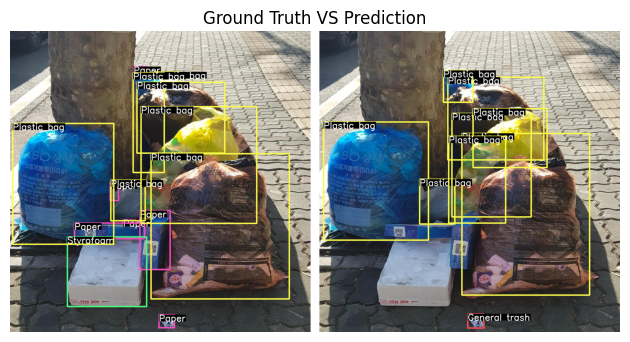

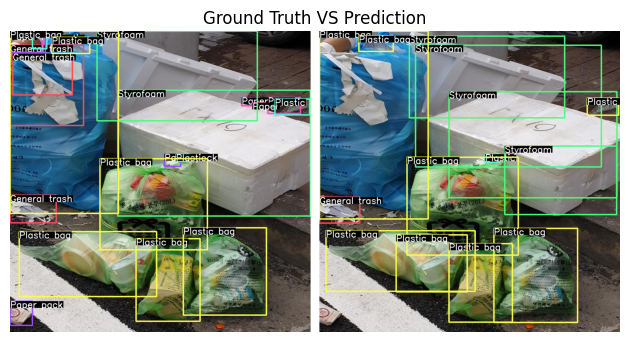

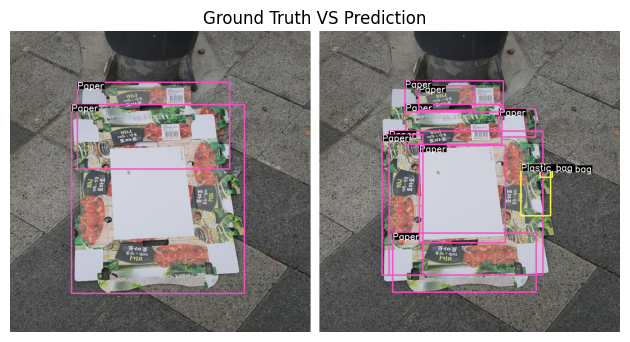

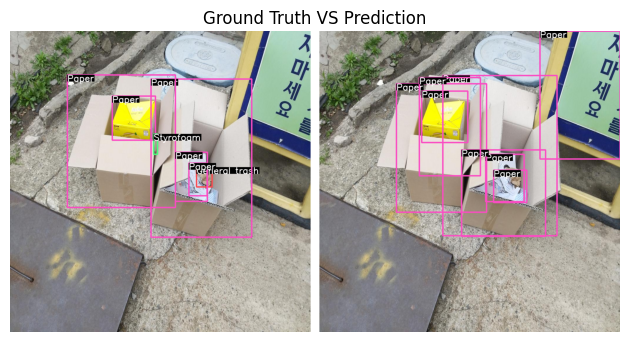

In [236]:
for key, (many_gt, many_pred) in pred.items():
    img_df = df.iloc[img_df_idx[key]].reset_index()
    path_ = img_df['img_path'].iloc[0].split('/')
    img_path = os.path.join(data_root, path_[-2], path_[-1])
    img_pred = show_result(img_path, many_pred, class_names, colors, score_thr=score_thr)
    img_gt = show_result(img_path, many_gt, class_names, colors, score_thr=0.0)
    line = np.ones((1024,30,3), dtype='uint8')*255
    img = np.concatenate((img_gt, line, img_pred), axis=1)
    plt.imshow(img)
    plt.title('Ground Truth VS Prediction')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

- 원하는 Image 살펴보기

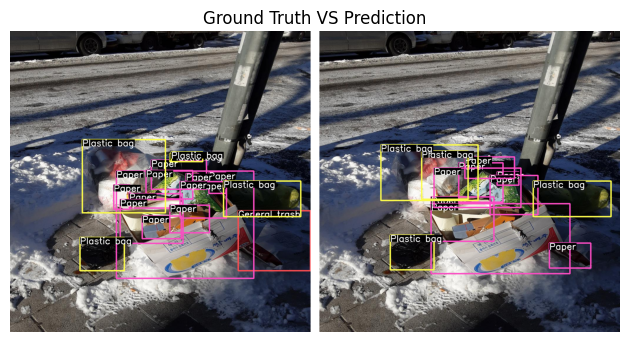

In [234]:
key = 2562
many_gt, many_pred = both[key]
img_df = df.iloc[img_df_idx[key]].reset_index()
path_ = img_df['img_path'].iloc[0].split('/')
img_path = os.path.join(data_root, path_[-2], path_[-1])
img_pred = show_result(img_path, many_pred, class_names, colors, score_thr=score_thr)
img_gt = show_result(img_path, many_gt, class_names, colors, score_thr=0.0)
line = np.ones((1024,30,3), dtype='uint8')*255
img = np.concatenate((img_gt, line, img_pred), axis=1)
plt.imshow(img)
plt.title('Ground Truth VS Prediction')
plt.axis('off')
plt.tight_layout()
plt.show()